# Seminar 6

# Dataset

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the `FashionMNIST` images are stored in a directory `img_dir`, and their labels are stored separately in a `CSV` file `annotations_file`.

In [4]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Transforms

In [ ]:
# https://pytorch.org/vision/stable/transforms.html
# https://github.com/albumentations-team/albumentations

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

### CSV example

# Data for training and testing

https://pytorch.org/docs/stable/data.html
* Map-style and iterable-style datasets.
* Customizing data loading order.
* Automatic batching.
* Single- and multi-process data loading (`num_workers`).
* Automatic memory pinning.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# MNIST, пример из первого семинара.

import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dataset = torchvision.datasets.MNIST(
    root='datasets',
    download=True,
    train=True,
    transform=transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap='gray')
plt.show()

print(f'Label: {label}')

### Get device

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

# Neural network

In [8]:
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)

In [ ]:
mobilenet_v2

In [ ]:
import torch.nn as nn

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.mobilenet_v2().features
        self.classifier = torch.nn.Linear(
            in_features=1280,
            out_features=10,
        )

    def forward(self, x):
        features = self.encoder(x)
        
        features_pooled = nn.functional.adaptive_avg_pool2d(
            input=features,
            output_size=(1, 1),
        )
        
        features_flattened = torch.flatten(features_pooled, 1)
        
        logits = self.classifier(features_flattened)
        return logits

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
model

### Evaluate

In [ ]:
X = torch.rand((1, 3, 224, 224), device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'Predicted class: {y_pred}')

### Tensorboard

In [19]:
# https://pytorch.org/docs/stable/tensorboard.html

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

In [15]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
# ...log the running loss
writer.add_scalar(
    tag='training loss',
    scalar_value=running_loss / 1000,
    global_step=epoch * len(trainloader) + i,
)

# ...log a Matplotlib Figure showing the model's predictions on a
# random mini-batch
writer.add_figure(
    'predictions vs. actuals',
    plot_classes_preds(net, inputs, labels),
    global_step=epoch * len(trainloader) + i,
)

In [ ]:
!tensorboard --logdir runs/fashion_mnist_experiment_1 --port ...

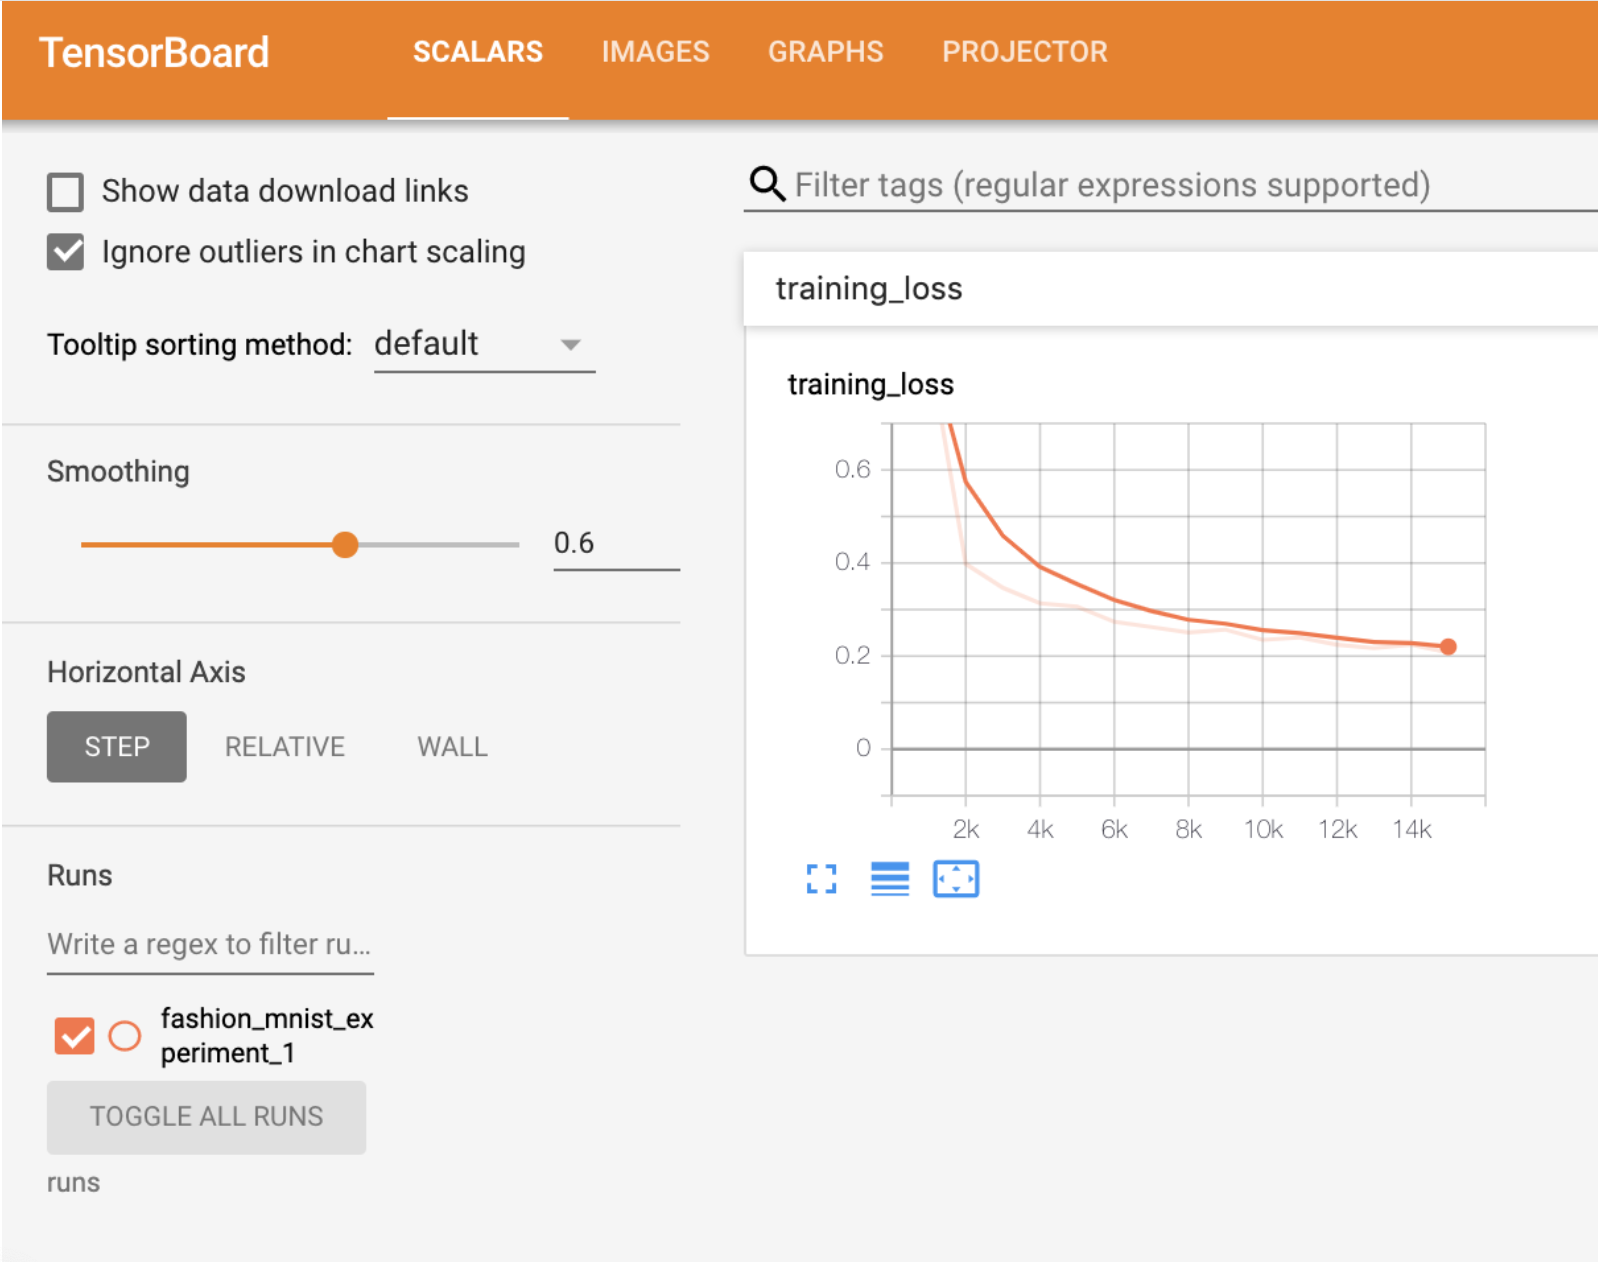

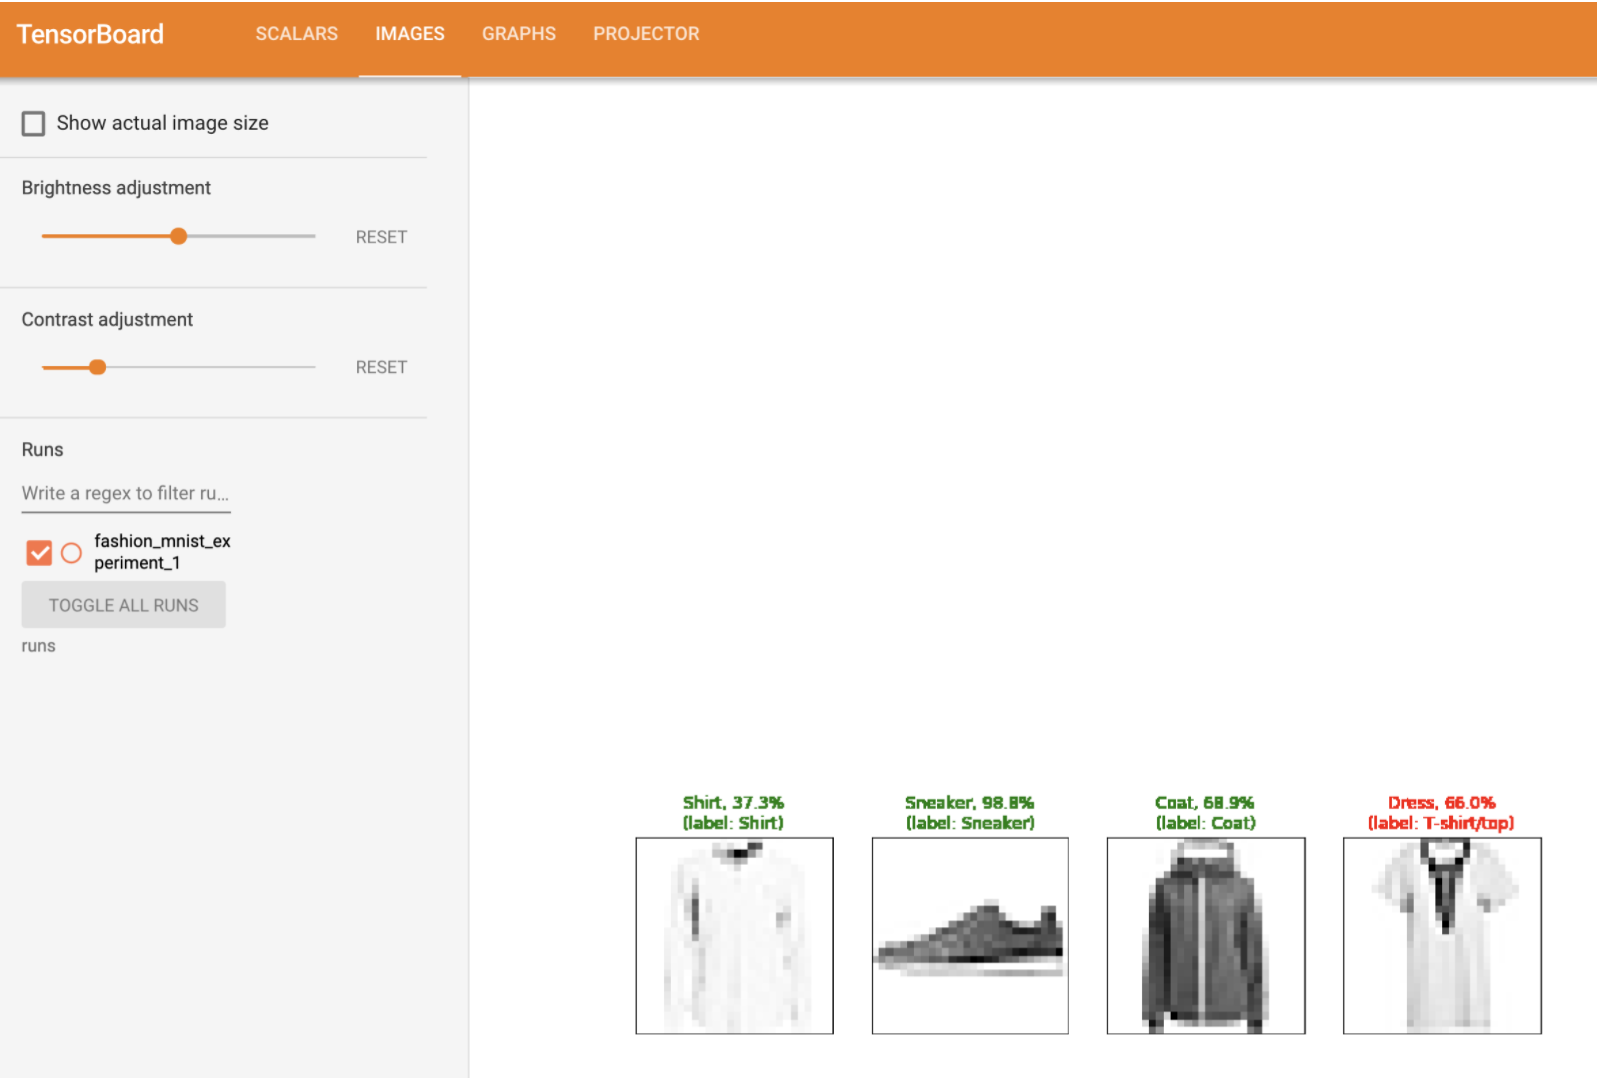

# Transfer learning

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* Augmentations (https://albumentations.ai/docs/examples/pytorch_classification/).
* Regularizers (Dropout, WD).
* Optimizers.
* Learning rate (annealing).
* Number of epochs.
* Neural network.
* Loss.

* Train/val loop (see 1, 2 seminar)

# Detection

### Torchvision

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### MMdetection

https://mmdetection.readthedocs.io/en/latest/1_exist_data_model.html

In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Specify the path to model config and checkpoint file
config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = 'test.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
model.show_result(img, result)
# or save the visualization results to image files
model.show_result(img, result, out_file='result.jpg')

# test a video and show the results
video = mmcv.VideoReader('video.mp4')
for frame in video:
    result = inference_detector(model, frame)
    model.show_result(frame, result, wait_time=1)

To evaluate a model’s accuracy, one usually tests the model on some standard datasets. `MMDetection` supports multiple public datasets including COCO, Pascal VOC, CityScapes

### Prepare datasets

Public datasets like Pascal VOC or mirror and COCO are available from official websites or mirrors. Note: In the detection task, Pascal VOC 2012 is an extension of Pascal VOC 2007 without overlap, and we usually use them together. It is recommended to download and extract the dataset somewhere outside the project directory and symlink the dataset root to $MMDETECTION/data as below. If your folder structure is different, you may need to change the corresponding paths in config files.

We provide a script to download datasets such as COCO , you can run  
`python tools/misc/download_dataset.py --dataset-name coco2017`  
to download COCO dataset.

For more usage please refer to dataset-download

In [ ]:
python tools/test.py \
    ${CONFIG_FILE} \
    ${CHECKPOINT_FILE} \
    [--out ${RESULT_FILE}] \
    [--eval ${EVAL_METRICS}] \
    [--show]

In [ ]:
python tools/train.py \
    ${CONFIG_FILE} \
    [optional arguments]

There are three ways to support a new dataset in MMDetection:
* reorganize the dataset into COCO format.
* reorganize the dataset into a middle format.
* implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.
In this note, we give an example for converting the data into COCO format.

### COCO annotation format
The necessary keys of COCO format for instance segmentation is as below, for the complete details, please refer here.

In [ ]:
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}


image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}

annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}

categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]

In [ ]:
# The new config inherits a base config to highlight the necessary modification
_base_ = 'mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=1),
        mask_head=dict(num_classes=1)))

# Modify dataset related settings
dataset_type = 'COCODataset'
classes = ('balloon',)
data = dict(
    train=dict(
        img_prefix='balloon/train/',
        classes=classes,
        ann_file='balloon/train/annotation_coco.json'),
    val=dict(
        img_prefix='balloon/val/',
        classes=classes,
        ann_file='balloon/val/annotation_coco.json'),
    test=dict(
        img_prefix='balloon/val/',
        classes=classes,
        ann_file='balloon/val/annotation_coco.json'))

# We can use the pre-trained Mask RCNN model to obtain higher performance
load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

In [ ]:
# The new config inherits the base configs to highlight the necessary modification
_base_ = [
    '../_base_/models/cascade_mask_rcnn_r50_fpn.py',
    '../_base_/datasets/cityscapes_instance.py', '../_base_/default_runtime.py'
]

model = dict(
    # set None to avoid loading ImageNet pretrained backbone,
    # instead here we set `load_from` to load from COCO pretrained detectors.
    backbone=dict(init_cfg=None),
    # replace neck from defaultly `FPN` to our new implemented module `AugFPN`
    neck=dict(
        type='AugFPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    # We also need to change the num_classes in head from 80 to 8, to match the
    # cityscapes dataset's annotation. This modification involves `bbox_head` and `mask_head`.
    roi_head=dict(
        bbox_head=[
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                # change the number of classes from defaultly COCO to cityscapes
                num_classes=8,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.1, 0.1, 0.2, 0.2]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                               loss_weight=1.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                # change the number of classes from defaultly COCO to cityscapes
                num_classes=8,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.05, 0.05, 0.1, 0.1]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                               loss_weight=1.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                # change the number of classes from defaultly COCO to cityscapes
                num_classes=8,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.033, 0.033, 0.067, 0.067]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
        ],
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            # change the number of classes from defaultly COCO to cityscapes
            num_classes=8,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))))

# over-write `train_pipeline` for new added `AutoAugment` training setting
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(
        type='AutoAugment',
        policies=[
            [dict(
                 type='Rotate',
                 level=5,
                 img_fill_val=(124, 116, 104),
                 prob=0.5,
                 scale=1)
            ],
            [dict(type='Rotate', level=7, img_fill_val=(124, 116, 104)),
             dict(
                 type='Translate',
                 level=5,
                 prob=0.5,
                 img_fill_val=(124, 116, 104))
            ],
        ]),
    dict(
        type='Resize', img_scale=[(2048, 800), (2048, 1024)], keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]

# set batch_size per gpu, and set new training pipeline
data = dict(
    samples_per_gpu=1,
    workers_per_gpu=3,
    # over-write `pipeline` with new training pipeline setting
    train=dict(dataset=dict(pipeline=train_pipeline)))

# Set optimizer
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# Set customized learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8])
runner = dict(type='EpochBasedRunner', max_epochs=10)

# We can use the COCO pretrained Cascade Mask R-CNN R50 model for more stable performance initialization
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_mask_rcnn_r50_fpn_1x_coco/cascade_mask_rcnn_r50_fpn_1x_coco_20200203-9d4dcb24.pth'

In [ ]:
model = dict(
    type='MaskRCNN',  # The name of detector
    backbone=dict(  # The config of backbone
        type='ResNet',  # The type of the backbone, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/backbones/resnet.py#L308 for more details.
        depth=50,  # The depth of backbone, usually it is 50 or 101 for ResNet and ResNext backbones.
        num_stages=4,  # Number of stages of the backbone.
        out_indices=(0, 1, 2, 3),  # The index of output feature maps produced in each stages
        frozen_stages=1,  # The weights in the first 1 stage are frozen
        norm_cfg=dict(  # The config of normalization layers.
            type='BN',  # Type of norm layer, usually it is BN or GN
            requires_grad=True),  # Whether to train the gamma and beta in BN
        norm_eval=True,  # Whether to freeze the statistics in BN
        style='pytorch'， # The style of backbone, 'pytorch' means that stride 2 layers are in 3x3 conv, 'caffe' means stride 2 layers are in 1x1 convs.
    	init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),  # The ImageNet pretrained backbone to be loaded
    neck=dict(
        type='FPN',  # The neck of detector is FPN. We also support 'NASFPN', 'PAFPN', etc. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/necks/fpn.py#L10 for more details.
        in_channels=[256, 512, 1024, 2048],  # The input channels, this is consistent with the output channels of backbone
        out_channels=256,  # The output channels of each level of the pyramid feature map
        num_outs=5),  # The number of output scales
    rpn_head=dict(
        type='RPNHead',  # The type of RPN head is 'RPNHead', we also support 'GARPNHead', etc. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/dense_heads/rpn_head.py#L12 for more details.
        in_channels=256,  # The input channels of each input feature map, this is consistent with the output channels of neck
        feat_channels=256,  # Feature channels of convolutional layers in the head.
        anchor_generator=dict(  # The config of anchor generator
            type='AnchorGenerator',  # Most of methods use AnchorGenerator, SSD Detectors uses `SSDAnchorGenerator`. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/anchor/anchor_generator.py#L10 for more details
            scales=[8],  # Basic scale of the anchor, the area of the anchor in one position of a feature map will be scale * base_sizes
            ratios=[0.5, 1.0, 2.0],  # The ratio between height and width.
            strides=[4, 8, 16, 32, 64]),  # The strides of the anchor generator. This is consistent with the FPN feature strides. The strides will be taken as base_sizes if base_sizes is not set.
        bbox_coder=dict(  # Config of box coder to encode and decode the boxes during training and testing
            type='DeltaXYWHBBoxCoder',  # Type of box coder. 'DeltaXYWHBBoxCoder' is applied for most of methods. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/bbox/coder/delta_xywh_bbox_coder.py#L9 for more details.
            target_means=[0.0, 0.0, 0.0, 0.0],  # The target means used to encode and decode boxes
            target_stds=[1.0, 1.0, 1.0, 1.0]),  # The standard variance used to encode and decode boxes
        loss_cls=dict(  # Config of loss function for the classification branch
            type='CrossEntropyLoss',  # Type of loss for classification branch, we also support FocalLoss etc.
            use_sigmoid=True,  # RPN usually perform two-class classification, so it usually uses sigmoid function.
            loss_weight=1.0),  # Loss weight of the classification branch.
        loss_bbox=dict(  # Config of loss function for the regression branch.
            type='L1Loss',  # Type of loss, we also support many IoU Losses and smooth L1-loss, etc. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/losses/smooth_l1_loss.py#L56 for implementation.
            loss_weight=1.0)),  # Loss weight of the regression branch.
    roi_head=dict(  # RoIHead encapsulates the second stage of two-stage/cascade detectors.
        type='StandardRoIHead',  # Type of the RoI head. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/roi_heads/standard_roi_head.py#L10 for implementation.
        bbox_roi_extractor=dict(  # RoI feature extractor for bbox regression.
            type='SingleRoIExtractor',  # Type of the RoI feature extractor, most of methods uses SingleRoIExtractor. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/roi_heads/roi_extractors/single_level.py#L10 for details.
            roi_layer=dict(  # Config of RoI Layer
                type='RoIAlign',  # Type of RoI Layer, DeformRoIPoolingPack and ModulatedDeformRoIPoolingPack are also supported. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/ops/roi_align/roi_align.py#L79 for details.
                output_size=7,  # The output size of feature maps.
                sampling_ratio=0),  # Sampling ratio when extracting the RoI features. 0 means adaptive ratio.
            out_channels=256,  # output channels of the extracted feature.
            featmap_strides=[4, 8, 16, 32]),  # Strides of multi-scale feature maps. It should be consistent to the architecture of the backbone.
        bbox_head=dict(  # Config of box head in the RoIHead.
            type='Shared2FCBBoxHead',  # Type of the bbox head, Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/roi_heads/bbox_heads/convfc_bbox_head.py#L177 for implementation details.
            in_channels=256,  # Input channels for bbox head. This is consistent with the out_channels in roi_extractor
            fc_out_channels=1024,  # Output feature channels of FC layers.
            roi_feat_size=7,  # Size of RoI features
            num_classes=80,  # Number of classes for classification
            bbox_coder=dict(  # Box coder used in the second stage.
                type='DeltaXYWHBBoxCoder',  # Type of box coder. 'DeltaXYWHBBoxCoder' is applied for most of methods.
                target_means=[0.0, 0.0, 0.0, 0.0],  # Means used to encode and decode box
                target_stds=[0.1, 0.1, 0.2, 0.2]),  # Standard variance for encoding and decoding. It is smaller since the boxes are more accurate. [0.1, 0.1, 0.2, 0.2] is a conventional setting.
            reg_class_agnostic=False,  # Whether the regression is class agnostic.
            loss_cls=dict(  # Config of loss function for the classification branch
                type='CrossEntropyLoss',  # Type of loss for classification branch, we also support FocalLoss etc.
                use_sigmoid=False,  # Whether to use sigmoid.
                loss_weight=1.0),  # Loss weight of the classification branch.
            loss_bbox=dict(  # Config of loss function for the regression branch.
                type='L1Loss',  # Type of loss, we also support many IoU Losses and smooth L1-loss, etc.
                loss_weight=1.0)),  # Loss weight of the regression branch.
        mask_roi_extractor=dict(  # RoI feature extractor for mask generation.
            type='SingleRoIExtractor',  # Type of the RoI feature extractor, most of methods uses SingleRoIExtractor.
            roi_layer=dict(  # Config of RoI Layer that extracts features for instance segmentation
                type='RoIAlign',  # Type of RoI Layer, DeformRoIPoolingPack and ModulatedDeformRoIPoolingPack are also supported
                output_size=14,  # The output size of feature maps.
                sampling_ratio=0),  # Sampling ratio when extracting the RoI features.
            out_channels=256,  # Output channels of the extracted feature.
            featmap_strides=[4, 8, 16, 32]),  # Strides of multi-scale feature maps.
        mask_head=dict(  # Mask prediction head
            type='FCNMaskHead',  # Type of mask head, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py#L21 for implementation details.
            num_convs=4,  # Number of convolutional layers in mask head.
            in_channels=256,  # Input channels, should be consistent with the output channels of mask roi extractor.
            conv_out_channels=256,  # Output channels of the convolutional layer.
            num_classes=80,  # Number of class to be segmented.
            loss_mask=dict(  # Config of loss function for the mask branch.
                type='CrossEntropyLoss',  # Type of loss used for segmentation
                use_mask=True,  # Whether to only train the mask in the correct class.
                loss_weight=1.0))))  # Loss weight of mask branch.
    train_cfg = dict(  # Config of training hyperparameters for rpn and rcnn
        rpn=dict(  # Training config of rpn
            assigner=dict(  # Config of assigner
                type='MaxIoUAssigner',  # Type of assigner, MaxIoUAssigner is used for many common detectors. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/bbox/assigners/max_iou_assigner.py#L10 for more details.
                pos_iou_thr=0.7,  # IoU >= threshold 0.7 will be taken as positive samples
                neg_iou_thr=0.3,  # IoU < threshold 0.3 will be taken as negative samples
                min_pos_iou=0.3,  # The minimal IoU threshold to take boxes as positive samples
                match_low_quality=True,  # Whether to match the boxes under low quality (see API doc for more details).
                ignore_iof_thr=-1),  # IoF threshold for ignoring bboxes
            sampler=dict(  # Config of positive/negative sampler
                type='RandomSampler',  # Type of sampler, PseudoSampler and other samplers are also supported. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/bbox/samplers/random_sampler.py#L8 for implementation details.
                num=256,  # Number of samples
                pos_fraction=0.5,  # The ratio of positive samples in the total samples.
                neg_pos_ub=-1,  # The upper bound of negative samples based on the number of positive samples.
                add_gt_as_proposals=False),  # Whether add GT as proposals after sampling.
            allowed_border=-1,  # The border allowed after padding for valid anchors.
            pos_weight=-1,  # The weight of positive samples during training.
            debug=False),  # Whether to set the debug mode
        rpn_proposal=dict(  # The config to generate proposals during training
            nms_across_levels=False,  # Whether to do NMS for boxes across levels. Only work in `GARPNHead`, naive rpn does not support do nms cross levels.
            nms_pre=2000,  # The number of boxes before NMS
            nms_post=1000,  # The number of boxes to be kept by NMS, Only work in `GARPNHead`.
            max_per_img=1000,  # The number of boxes to be kept after NMS.
            nms=dict( # Config of NMS
                type='nms',  # Type of NMS
                iou_threshold=0.7 # NMS threshold
                ),
            min_bbox_size=0),  # The allowed minimal box size
        rcnn=dict(  # The config for the roi heads.
            assigner=dict(  # Config of assigner for second stage, this is different for that in rpn
                type='MaxIoUAssigner',  # Type of assigner, MaxIoUAssigner is used for all roi_heads for now. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/bbox/assigners/max_iou_assigner.py#L10 for more details.
                pos_iou_thr=0.5,  # IoU >= threshold 0.5 will be taken as positive samples
                neg_iou_thr=0.5,  # IoU < threshold 0.5 will be taken as negative samples
                min_pos_iou=0.5,  # The minimal IoU threshold to take boxes as positive samples
                match_low_quality=False,  # Whether to match the boxes under low quality (see API doc for more details).
                ignore_iof_thr=-1),  # IoF threshold for ignoring bboxes
            sampler=dict(
                type='RandomSampler',  # Type of sampler, PseudoSampler and other samplers are also supported. Refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/bbox/samplers/random_sampler.py#L8 for implementation details.
                num=512,  # Number of samples
                pos_fraction=0.25,  # The ratio of positive samples in the total samples.
                neg_pos_ub=-1,  # The upper bound of negative samples based on the number of positive samples.
                add_gt_as_proposals=True
            ),  # Whether add GT as proposals after sampling.
            mask_size=28,  # Size of mask
            pos_weight=-1,  # The weight of positive samples during training.
            debug=False))  # Whether to set the debug mode
    test_cfg = dict(  # Config for testing hyperparameters for rpn and rcnn
        rpn=dict(  # The config to generate proposals during testing
            nms_across_levels=False,  # Whether to do NMS for boxes across levels. Only work in `GARPNHead`, naive rpn does not support do nms cross levels.
            nms_pre=1000,  # The number of boxes before NMS
            nms_post=1000,  # The number of boxes to be kept by NMS, Only work in `GARPNHead`.
            max_per_img=1000,  # The number of boxes to be kept after NMS.
            nms=dict( # Config of NMS
                type='nms',  #Type of NMS
                iou_threshold=0.7 # NMS threshold
                ),
            min_bbox_size=0),  # The allowed minimal box size
        rcnn=dict(  # The config for the roi heads.
            score_thr=0.05,  # Threshold to filter out boxes
            nms=dict(  # Config of NMS in the second stage
                type='nms',  # Type of NMS
                iou_thr=0.5),  # NMS threshold
            max_per_img=100,  # Max number of detections of each image
            mask_thr_binary=0.5))  # Threshold of mask prediction
dataset_type = 'CocoDataset'  # Dataset type, this will be used to define the dataset
data_root = 'data/coco/'  # Root path of data
img_norm_cfg = dict(  # Image normalization config to normalize the input images
    mean=[123.675, 116.28, 103.53],  # Mean values used to pre-training the pre-trained backbone models
    std=[58.395, 57.12, 57.375],  # Standard variance used to pre-training the pre-trained backbone models
    to_rgb=True
)  # The channel orders of image used to pre-training the pre-trained backbone models
train_pipeline = [  # Training pipeline
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='LoadAnnotations',  # Second pipeline to load annotations for current image
        with_bbox=True,  # Whether to use bounding box, True for detection
        with_mask=True,  # Whether to use instance mask, True for instance segmentation
        poly2mask=False),  # Whether to convert the polygon mask to instance mask, set False for acceleration and to save memory
    dict(
        type='Resize',  # Augmentation pipeline that resize the images and their annotations
        img_scale=(1333, 800),  # The largest scale of image
        keep_ratio=True
    ),  # whether to keep the ratio between height and width.
    dict(
        type='RandomFlip',  # Augmentation pipeline that flip the images and their annotations
        flip_ratio=0.5),  # The ratio or probability to flip
    dict(
        type='Normalize',  # Augmentation pipeline that normalize the input images
        mean=[123.675, 116.28, 103.53],  # These keys are the same of img_norm_cfg since the
        std=[58.395, 57.12, 57.375],  # keys of img_norm_cfg are used here as arguments
        to_rgb=True),
    dict(
        type='Pad',  # Padding config
        size_divisor=32),  # The number the padded images should be divisible
    dict(type='DefaultFormatBundle'),  # Default format bundle to gather data in the pipeline
    dict(
        type='Collect',  # Pipeline that decides which keys in the data should be passed to the detector
        keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='MultiScaleFlipAug',  # An encapsulation that encapsulates the testing augmentations
        img_scale=(1333, 800),  # Decides the largest scale for testing, used for the Resize pipeline
        flip=False,  # Whether to flip images during testing
        transforms=[
            dict(type='Resize',  # Use resize augmentation
                 keep_ratio=True),  # Whether to keep the ratio between height and width, the img_scale set here will be suppressed by the img_scale set above.
            dict(type='RandomFlip'),  # Thought RandomFlip is added in pipeline, it is not used because flip=False
            dict(
                type='Normalize',  # Normalization config, the values are from img_norm_cfg
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(
                type='Pad',  # Padding config to pad images divisible by 32.
                size_divisor=32),
            dict(
                type='ImageToTensor',  # convert image to tensor
                keys=['img']),
            dict(
                type='Collect',  # Collect pipeline that collect necessary keys for testing.
                keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,  # Batch size of a single GPU
    workers_per_gpu=2,  # Worker to pre-fetch data for each single GPU
    train=dict(  # Train dataset config
        type='CocoDataset',  # Type of dataset, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/datasets/coco.py#L19 for details.
        ann_file='data/coco/annotations/instances_train2017.json',  # Path of annotation file
        img_prefix='data/coco/train2017/',  # Prefix of image path
        pipeline=[  # pipeline, this is passed by the train_pipeline created before.
            dict(type='LoadImageFromFile'),
            dict(
                type='LoadAnnotations',
                with_bbox=True,
                with_mask=True,
                poly2mask=False),
            dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(
                type='Collect',
                keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
        ]),
    val=dict(  # Validation dataset config
        type='CocoDataset',
        ann_file='data/coco/annotations/instances_val2017.json',
        img_prefix='data/coco/val2017/',
        pipeline=[  # Pipeline is passed by test_pipeline created before
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(  # Test dataset config, modify the ann_file for test-dev/test submission
        type='CocoDataset',
        ann_file='data/coco/annotations/instances_val2017.json',
        img_prefix='data/coco/val2017/',
        pipeline=[  # Pipeline is passed by test_pipeline created before
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ],
        samples_per_gpu=2  # Batch size of a single GPU used in testing
        ))
evaluation = dict(  # The config to build the evaluation hook, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/evaluation/eval_hooks.py#L7 for more details.
    interval=1,  # Evaluation interval
    metric=['bbox', 'segm'])  # Metrics used during evaluation
optimizer = dict(  # Config used to build optimizer, support all the optimizers in PyTorch whose arguments are also the same as those in PyTorch
    type='SGD',  # Type of optimizers, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/optimizer/default_constructor.py#L13 for more details
    lr=0.02,  # Learning rate of optimizers, see detail usages of the parameters in the documentation of PyTorch
    momentum=0.9,  # Momentum
    weight_decay=0.0001)  # Weight decay of SGD
optimizer_config = dict(  # Config used to build the optimizer hook, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/optimizer.py#L8 for implementation details.
    grad_clip=None)  # Most of the methods do not use gradient clip
lr_config = dict(  # Learning rate scheduler config used to register LrUpdater hook
    policy='step',  # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    warmup='linear',  # The warmup policy, also support `exp` and `constant`.
    warmup_iters=500,  # The number of iterations for warmup
    warmup_ratio=
    0.001,  # The ratio of the starting learning rate used for warmup
    step=[8, 11])  # Steps to decay the learning rate
runner = dict(
    type='EpochBasedRunner', # Type of runner to use (i.e. IterBasedRunner or EpochBasedRunner)
    max_epochs=12) # Runner that runs the workflow in total max_epochs. For IterBasedRunner use `max_iters`
checkpoint_config = dict(  # Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
    interval=1)  # The save interval is 1
log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        # dict(type='TensorboardLoggerHook')  # The Tensorboard logger is also supported
        dict(type='TextLoggerHook')
    ])  # The logger used to record the training process.
dist_params = dict(backend='nccl')  # Parameters to setup distributed training, the port can also be set.
log_level = 'INFO'  # The level of logging.
load_from = None  # load models as a pre-trained model from a given path. This will not resume training.
resume_from = None  # Resume checkpoints from a given path, the training will be resumed from the epoch when the checkpoint's is saved.
workflow = [('train', 1)]  # Workflow for runner. [('train', 1)] means there is only one workflow and the workflow named 'train' is executed once. The workflow trains the model by 12 epochs according to the total_epochs.
work_dir = 'work_dir'  # Directory to save the model checkpoints and logs for the current experiments.

### Yolo

https://github.com/ultralytics/yolov5